## Object Removal

### This notebook introduces object removal from the input images. The implementation incorporates mask selection using the SAM model and applies diffusion by making use of Latent Diffusion Model. In this notebook, we will provide a step-by-step guide to erasing the unwanted elements from a given image.

Define an input image

In [24]:
from PIL import Image
import os, sys

input_path = '../inputs/eraser/oscar3.png'
input_image = Image.open(input_path).convert("RGB")

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
sys.path.append(os.path.join(parent_dir, 'code'))

Generate a mask, using previously introduced SAM model

In [25]:
from mask_sam import get_mask
import numpy as np

input_image_array = np.array(input_image)
mask_image = get_mask(input_image_array, ([[[400, 400]]]))
mask_array = np.where(mask_image, 255, 0).astype(np.uint8)

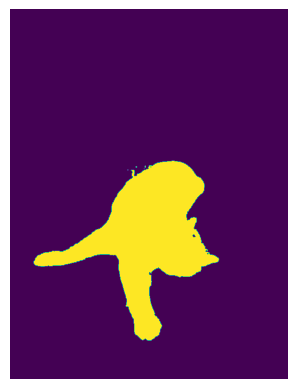

In [26]:
from matplotlib import pyplot as plt

plt.imshow(mask_image)
plt.axis('off')
plt.show()

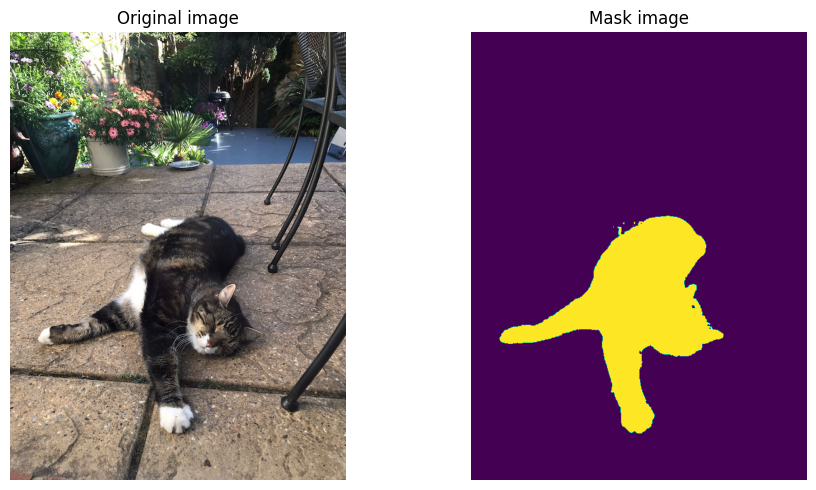

In [27]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(input_image)
axs[0].axis('off')  # Hide the axis
axs[0].set_title('Original image')  # Optionally set a title

# Display the second image in the right subplot
axs[1].imshow(mask_image)
axs[1].axis('off')  # Hide the axis
axs[1].set_title('Mask image')  # Optionally set a title

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

Define the number of inference steps

In [28]:
ddim_steps = 20

Resize the original image to $512$ x $512$, which is a prerequisite image size for the model

In [29]:
image = input_image
original_width, original_height = image.size

if original_width > original_height:
    image = image.resize((768, 512))
elif original_width < original_height:
    image = image.resize((512, 768))
else:
    image = image.resize((512, 512))

Resize the mask image to $512$ x $512$

In [34]:
from operations_image import expand_white_areas_outpainting

pil_mask = Image.fromarray(mask_array)
dil_iterations = 10
pil_mask_dilated = expand_white_areas_outpainting(pil_mask, iterations=dil_iterations)
mask = pil_mask_dilated

mask_original_width, mask_original_height = mask.size

if mask_original_width > mask_original_height:
    mask = mask.resize((768, 512))
elif mask_original_width < mask_original_height:
    mask = mask.resize((512, 768))
else:
    mask = mask.resize((512, 512))

Set up the configuration and model paths of Latent Diffusion

In [42]:
import os, sys
from omegaconf import OmegaConf
from tqdm import tqdm
import numpy as np
import torch


steps = int(ddim_steps)

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))

sys.path.append(os.path.join(parent_dir, 'latent-diffusion'))
sys.path.append(os.path.join(parent_dir, 'code'))

from main import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler

config = OmegaConf.load("../models/ldm_inpainting/config.yaml")
model = instantiate_from_config(config.model)
model.load_state_dict(torch.load("../models/ldm_inpainting/last.ckpt")["state_dict"], strict=False)

ModuleNotFoundError: No module named 'taming'

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)
sampler = DDIMSampler(model)

Infer the model on the input image and mask to obtain the output image

In [ ]:
from eraser_ldm import make_batch_gradio

with torch.no_grad():
    with model.ema_scope():

        batch = make_batch_gradio(image, mask, device=device)

        c = model.cond_stage_model.encode(batch["masked_image"])
        cc = torch.nn.functional.interpolate(batch["mask"],
                                            size=c.shape[-2:])
        c = torch.cat((c, cc), dim=1)

        shape = (c.shape[1]-1,)+c.shape[2:]
        samples_ddim, _ = sampler.sample(S=steps, ## changed
                                        conditioning=c,
                                        batch_size=c.shape[0],
                                        shape=shape,
                                        verbose=False)
        x_samples_ddim = model.decode_first_stage(samples_ddim)

        image = torch.clamp((batch["image"]+1.0)/2.0,
                            min=0.0, max=1.0)
        mask = torch.clamp((batch["mask"]+1.0)/2.0,
                        min=0.0, max=1.0)
        predicted_image = torch.clamp((x_samples_ddim+1.0)/2.0,
                                    min=0.0, max=1.0)

        inpainted = (1-mask)*image+mask*predicted_image
        inpainted = inpainted.cpu().numpy().transpose(0,2,3,1)[0]*255
        inpainted = Image.fromarray(inpainted.astype(np.uint8))
        inpainted = inpainted.resize((original_width, original_height))

In [ ]:
plt.imshow(inpainted)
plt.axis('off')
plt.show()

Visualise the final result

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(input_image)
axs[0].axis('off')
axs[0].set_title('Original image')

# Display the second image in the right subplot
axs[1].imshow(inpainted)
axs[1].axis('off')
axs[1].set_title('Final image')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()